In [101]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from random import shuffle

import time

%matplotlib inline

In [80]:
CARD_RANKING = {'Hn': 1, 'Hk': 2, 'Ha': 3,
                'Sn': 4, 'Sk': 5, 'St': 6, 'Sa': 7,
                'Cn': 8, 'Ck': 9, 'Ct': 10, 'Ca': 11, 
                'Dn': 12, 'Dk': 13, 'Dt': 14, 'Da': 15,
                'Dj': 16, 'Hj': 17, 'Sj': 18, 'Cj': 19,
                'Dq': 20, 'Hq': 21, 'Sq': 22, 'Cq': 23,
                'Ht': 24}

def change_key_and_values(mydict):
    """
    Changes keys and values of given dict
    Args:
        mydict: Dictionary containing key value pairs.
    Returns:
        mydict_inverse: Inverse dict.
    """
    mydict_inverse = {}
    
    for key, value in mydict.iteritems():
        mydict_inverse[value] = key
        
    return mydict_inverse

CARD_RANKING_INVERSE = change_key_and_values(CARD_RANKING)

CARD_CATEGORIES = {'Herz_Fehl' : ['Hn', 'Hk', 'Ha'],
                   'Pik_Fehl' : ['Sn', 'Sk', 'St', 'Sa'],
                   'Kreuz_Fehl' : ['Cn', 'Ck', 'Ct', 'Ca'],
                   'Fuechse' : ['Ca'],
                   'Res' : ['Cq'],
                   'hoeher_Fuchs': ['Dj', 'Hj', 'Sj', 'Cj',
                                 'Dq', 'Hq', 'Sq', 'Cq',
                                 'Ht'],
                   'Buben': ['Dj', 'Hj', 'Sj', 'Cj'],
                   'Damen': ['Dq', 'Hq', 'Sq', 'Cq'],
                   'Koenige': ['Dk', 'Hk', 'Sk', 'Ck']}

CARD_CATEGORIES_MAX_POSSIBLE = {}

for key, value in CARD_CATEGORIES.iteritems():
    CARD_CATEGORIES_MAX_POSSIBLE[key] = len(value)*2

In [81]:
# Basic functions to create decks of DoKo games


def create_deck(nines=False, mix=True):
    """
    This function will create a full doko deck with or without nines.
    Nomenclature: 
        H: hearts, D: diamonds, S: spades, C: clubs
        (n: 9) t: 10, j: jack, q: queen, k: king, a: ace
    Args:
        nines: If True, the deck will contain nines.
        mix: If True, the deck will be shuffeled randomly.
    Returns:
        complete_deck: List of all cards in a deck.
    """
    single_deck = ['Ht', 'Hj', 'Hq', 'Hk', 'Ha',
                   'Dt', 'Dj', 'Dq', 'Dk', 'Da',
                   'St', 'Sj', 'Sq', 'Sk', 'Sa',
                   'Ct', 'Cj', 'Cq', 'Ck', 'Ca']
    
    if nines is True:
        single_deck.extend(['Hn', 'Dn', 'Sn', 'Cn'])
        
    complete_deck = 2*single_deck
    
    if mix is True:
        shuffle(complete_deck)
    else:
        complete_deck = sort_deck(complete_deck)
            
    return np.array(complete_deck)


def sort_cards(cards):
    """
    Sorts given amount of cards. This function uses 
    the global variables CARD_RANKING and CARD_RANKING_INVERSE
    Args:
        deck: Arbitrary amount of cards.
    Returns:
        sorted_deck: A sorted deck.
    """
    card_ranks = [CARD_RANKING[card] for card in cards]
    sorted_card_ranks = sorted(card_ranks)
    sorted_cards = [CARD_RANKING_INVERSE[rank] for rank in sorted_card_ranks]
    
    return np.array(sorted_cards)


def create_sample(num_decks, nines=False):
    """
    Creates a complete test sample of cards, decks and hands in pandas
    DataFrame format.
    Args: 
        num_decks: Number of decks to create
        nines: If True, decks will be created with nines
    Returns:
        data: DataFrame containing decks and player hands
    """
    decks = np.array([create_deck(nines=nines) for _ in xrange(num_decks)])
    player_hands = decks.reshape(-1, 4, len(decks[0]) / 4)

    # Sort all player hands
    for hands in player_hands:
        for i, hand in enumerate(hands):
            hands[i]  = sort_cards(hand)
            
    # Create Pandas DataFrame
    data = pd.DataFrame()
    data["decks"] = [decks[i] for i in range(num_decks)]

    for i in range(4):
        data["hand_{}".format(i+1)] = [player_hands[j, i, :] for j in range(num_decks)]
        
    return data

In [82]:
# These functions are used for analysis of hands

def num_cards_in_cards_type(hand, card_category):
    cnt = 0
    for card in hand:
        if card in card_category: cnt += 1
    return cnt

def analyse_games(games):
    for cat_name, cat in CARD_CATEGORIES.iteritems():
        # For all hands in one game
        for j in range(4):
            games["hand_{}_num_{}".format(j + 1, cat_name)] = \
            games["hand_{}".format(j + 1)].apply(
                lambda x: num_cards_in_cards_type(x,cat))

    return games

In [102]:
# Generate games
cur_time = time.time()
num_samples = 100000

games = create_sample(num_samples)
games = analyse_games(games)
print("Creating and analysing {} decks in {:.3f} seconds".format(
      num_samples, time.time() - cur_time))

Creating and analysing 100000 decks in 15.274 seconds


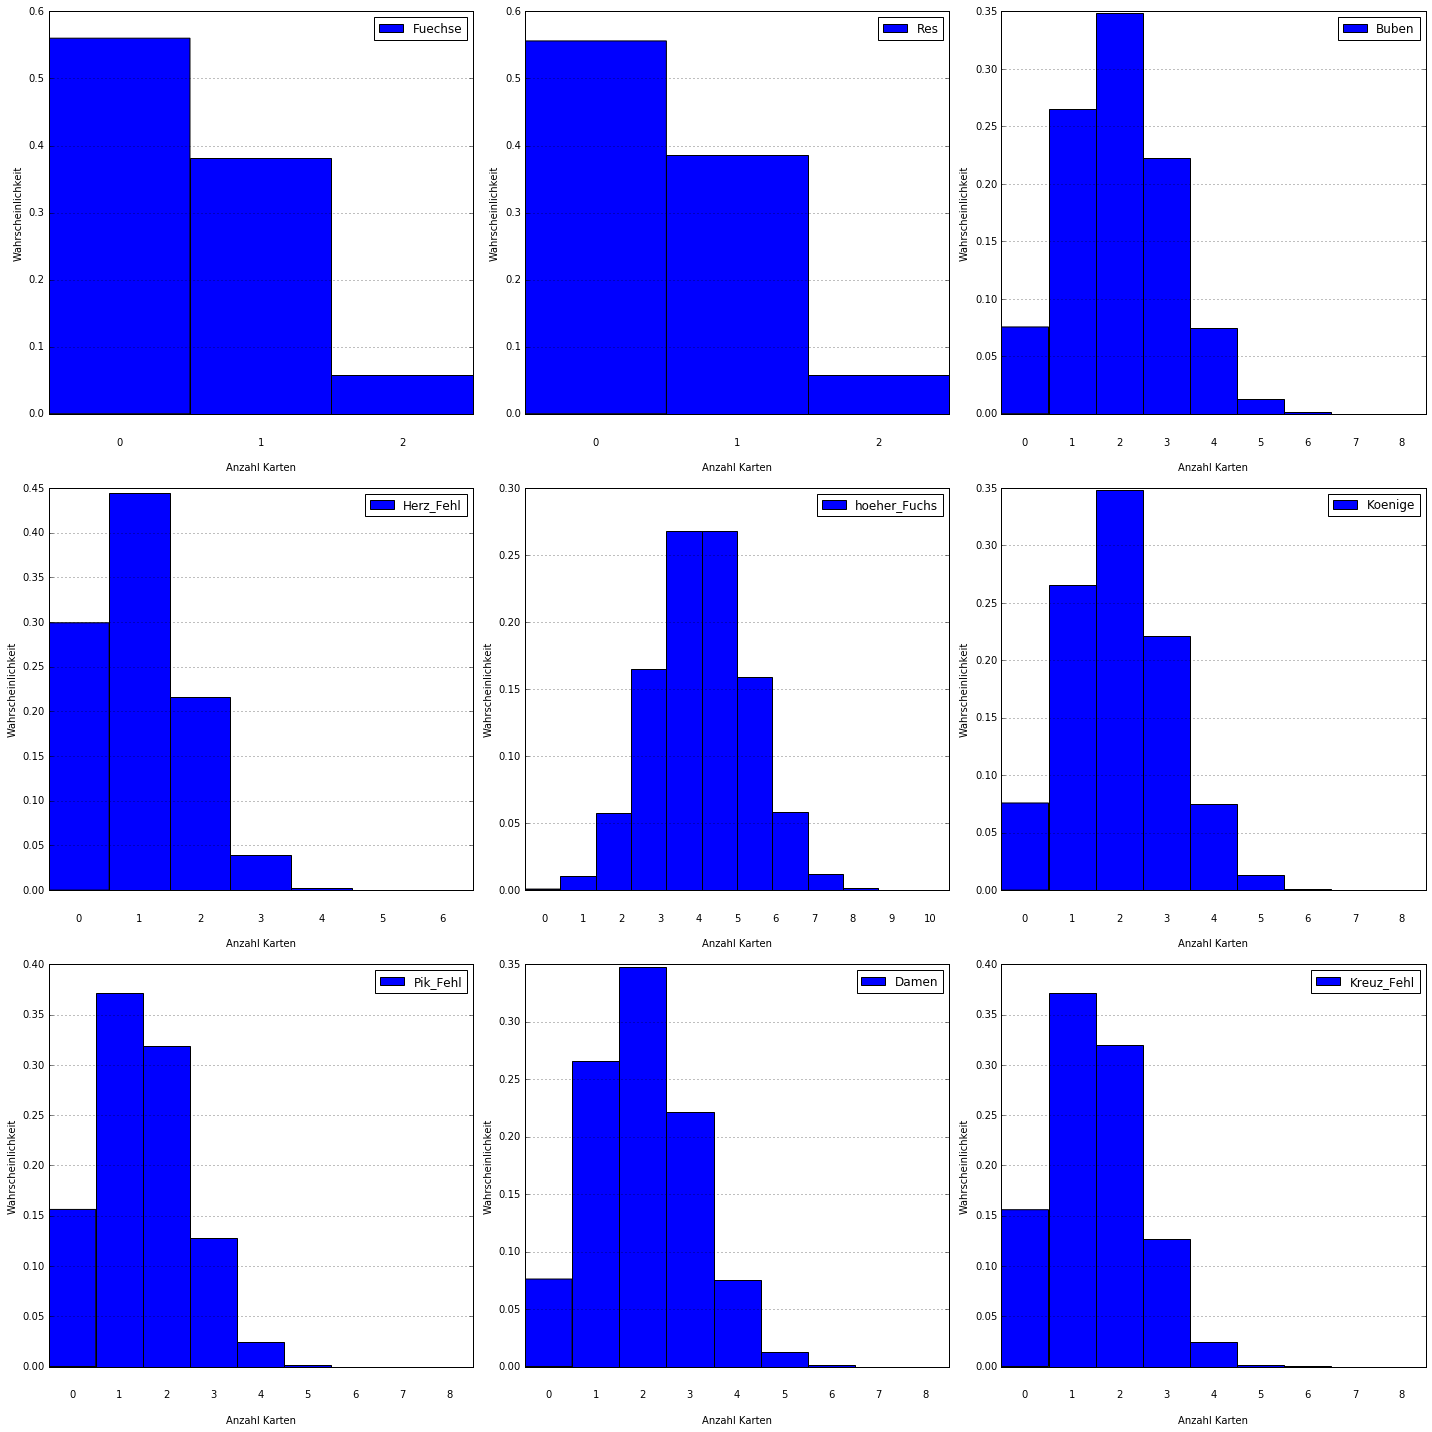

In [103]:
fig = plt.figure(figsize=(20,20))


for cnt, (key, value) in enumerate(CARD_CATEGORIES_MAX_POSSIBLE.iteritems()):
    ax = plt.subplot(3, 3, cnt + 1)
    
    # Check for maximum number of cards in Hand
    if value > len(games.hand_1[0]):
        value = len(games.hand_1[0])
    
    # Set Binning
    binning = np.linspace(0, value + 1, value + 2)
    
    # Do the plot
    games["hand_1_num_{}".format(key)].hist(normed=True, label=key, bins=binning)
    
    # Format x-Axis ticks (super ugly)
    bin_centers = 0.5 * np.diff(binning) + binning[:-1]
    for bin_center, bin_val in zip(bin_centers, binning):
        plt.annotate(str(int(bin_val)), xy=(0 + bin_center / max(binning), -0.07), xycoords='axes fraction',
                     horizontalalignment='center', verticalalignment='center')
    ax.xaxis.set_ticks([])
    
    # Add description etc.
    ax.set_xlabel("Anzahl Karten")
    ax.set_ylabel("Wahrscheinlichkeit")
    ax.xaxis.set_label_coords(0.5, -0.12)
    plt.legend()

fig.set_tight_layout(True)

fig.savefig("verteilungen.pdf")